## Set-up: Import packages, format figure style, and load data

In [46]:
import pandas as pd
import numpy as np
from itertools import combinations

from scipy.stats import mannwhitneyu, spearmanr

from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.patches import ConnectionPatch
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
import matplotlib.patches as mpatches

sns.set_style('darkgrid')

In [60]:
colors = ['#003DA6', '#B53A6D', '#7AC4A5', '#F17F4C', '#15AFD0']

basefont = mpl.font_manager.FontProperties(family='DejaVu Sans', style='normal', size=14)
mpl.rcParams['axes.titlesize'] = 14

plot_style = {
    'axes.grid': True,
    'axes.grid.axis': 'y',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': True,
    'axes.facecolor': 'w',
    'axes.edgecolor': 'black',
    'grid.color': '#aaaaaa',
    'grid.linewidth': '0.8',
    'grid.linestyle': '-',
    'axes.titlesize': 14,
    'legend.framealpha': 1.0,
    'errorbar.capsize': 8
}

plt.rcParams.update(plot_style)

In [3]:
df = pd.read_csv('../../Private/data_cleaned.csv')

# Figure 1: Respondent Demographics by Sector

Left hand plot values:
Academia                 311
Industry                 121
Government               15
Other                    1
——————————
Right hand plot values:
<50 Employees            17
50-100 Employees         9
101-500 Employees        9
>500 Employees           85


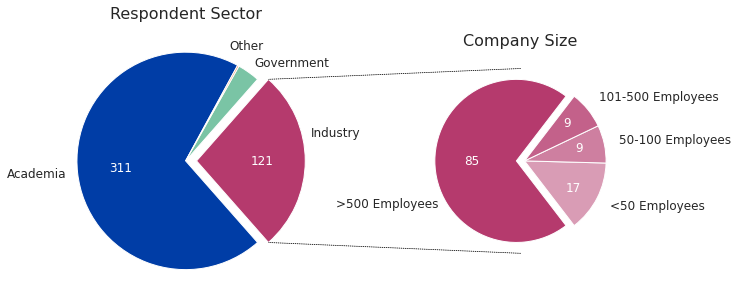

In [4]:
# Create a plot that will contain two pie charts within it
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 5))
fig.subplots_adjust(wspace=0)

# Extract the relevant counts from the data
counts = df.Sector.value_counts().tolist()
labels = df.Sector.value_counts().index[:-1].tolist() + ['Other']  # Use "Other" instead of "None of the above"

# Print the data that will be plotted
print('Left hand plot values:')
for lab, val in zip(labels, counts):
    print(f'{lab:<25s}{val}')
print('——————————')

# This caluclation finds the right starting angle to plot with, so that the middle of the industry slice lies on the horizontal axis
angle = 360 * ((sum(counts[1:]) - 0.5 * counts[1]) / sum(counts))

# Plot the left-hand pie chart, and save the returned matplotlib objects for the slices, the label texts, and the number texts on each slice
wedges, text, autotexts = ax0.pie(counts, labels = labels, colors = colors, startangle = angle, autopct='',  # For now, don't add numbers on the slices
                                  explode = [0, 0.1, 0, 0],  # The "industry" slice will be slightly pulled out of the center
                                  textprops = {'fontname': 'DejaVu Sans', 'fontsize': 12})

# Manually adjust the locations of some of the labels so that they don't overlap
text[1].set_y(0.25)
text[1].set_x(1.15)
text[3].set_y(1.05)
text[3].set_x(0.4)

# For academia and industry ONLY, add white numbers to the pie slices (the slices for government and other are too small)
for a, c in zip(autotexts[:2], counts[:2]):
    a.set_text(f'{c}')
    a.set_color('white')
    

# The right-hand side of the pie chart should consist of 4 different shades of the same red used to plot "industry" as a whole
inset_colors = [to_rgba(colors[1], alpha = a) for a in reversed([1., 0.8, 0.65, 0.5])]

# Extract the relevant counts and labels from the data
labels = ['<50 Employees', '50-100 Employees', '101-500 Employees', '>500 Employees']
counts = [len(df[(df.Sector == 'Industry') & (df.CompanySize == lab)]) for lab in labels]

# Print the data that will be plotted
print('Right hand plot values:')
for lab, val in zip(labels, counts):
    print(f'{lab:<25s}{val}')

# This calculation finds the right starting angle to plot with, such that the largest slice (>500 Employees) ends up facing left and horizontally aligned with the left-hand "industry" slice
angle = -360 * 0.5 * sum(counts[:-1]) / sum(counts)

# Plot the right-hand pie chart, and save the returned matplotlib objects for the slices, the label texts, and the number texts on each slice
# This one is more difficult because we want three slices (the "small" company slices) to be exploded as a *single* slice, not to be exploded separately
# To do this, we will first make a (white, non-visible) plot with each one exploded separately, but then manipulate the geometry of the slices and color them in
wedges, text, autotexts = ax1.pie(counts, labels = labels, startangle = angle, colors = ['white'] * 4,  # Colors are initially white because we will readjust the geometry of these slices later
                                  explode = [.1,.1,.1,0],  # Ensure that all three of the "small" company items are exploded (these will be reformatted into a single exploded slice, below)
                                  textprops = {'fontname': 'DejaVu Sans', 'fontsize': 12}, autopct='',  # As before, leave numbers blank for now
                                  radius = 0.75)  # Make this pie chart smaller than the left-hand one

# Manually adjust the locations of the ">500 Employees" label so that it doesn't overlap with a label from the left-hand graph
text[3].set_y(-0.4)
text[3].set_x(-0.75)

# The white patches will be overwritten with slightly adjusted red patches, so move them to the back of the image 
[w.set_zorder(-1) for w in wedges]


# The following code groups the three small company slices together and manipulates the geometry of both groups
groups = [[0,1,2], [3]]
radfraction = 0.05
patches = []
for i in groups:
    ang = np.deg2rad((wedges[i[-1]].theta2 + wedges[i[0]].theta1)/2,)
    for j in i:
        we = wedges[j]
        center = (radfraction*we.r*np.cos(ang), radfraction*we.r*np.sin(ang))
        patches.append(mpatches.Wedge(center, we.r, we.theta1, we.theta2))

# Create a patch collection object out of the geometrically adjusted slices, color them in, and add them to the right-hand plot
collection = PatchCollection(patches, cmap = LinearSegmentedColormap.from_list('custom_map', inset_colors, N=4))
collection.set_array(np.array([0,1,2,3]))
ax1.add_collection(collection)

# Add numerical labels to the slices in the right-hand plot in white font 
for a, c in zip(autotexts, counts):
    a.set_text(f'{c}')
    a.set_color('white')


# Drawing connecting lines
theta1, theta2 = ax0.patches[1].theta1, ax0.patches[1].theta2
center, r = ax0.patches[1].center, ax0.patches[1].r
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(0, .85), xyB=(x, y),
                      coordsA="data", coordsB="data", axesA=ax1, axesB=ax0)
con.set_color([0, 0, 0])
con.set_linewidth(0.8)
con.set_linestyle(':')
ax1.add_artist(con)

x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(0, -0.85), xyB=(x, y), coordsA="data",
                      coordsB="data", axesA=ax1, axesB=ax0)
con.set_color([0, 0, 0])
con.set_linewidth(0.8)
con.set_linestyle(':')
ax1.add_artist(con)

# Do some final visualization touch-up and save the figure 
ax0.set_title('Respondent Sector', fontsize=16, fontname='DejaVu Sans')
ax1.set_title('Company Size', fontsize=16, fontname='DejaVu Sans', y=.9)
fig.savefig('../figures/paper/Fig1.jpg', dpi=300, bbox_inches='tight')

plt.show()
plt.close()


# Figure 2: Respondent Demographics by Subfield

               CV   NLP    RL  Robotics  Other
Academia    107.0  96.0  62.0      61.0  123.0
Industry     49.0  58.0  17.0      13.0   48.0
Government    6.0   2.0   4.0       1.0    7.0


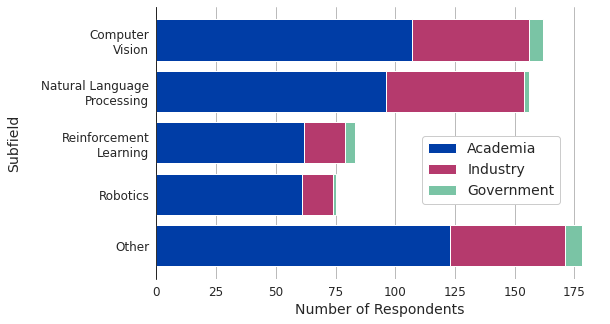

In [5]:
# Create a 3x5 matrix to hold the number of academics, industry researchers, and government researchers in each subfield, then loop over each possible combination
# NOTE: this excludes the one person who responded to the subfield question but did not identify as either an academic, industry researchers, or governemnt researcher
data = np.zeros((3, 5))
for i, s in enumerate(['Academia', 'Industry', 'Government']):
    for j, f in enumerate(['CV', 'NLP', 'RL', 'Robotics', 'Other']):
        data[i,j] = df[df.Sector == s][f].sum()
        
# Print the data being plotted
data_df = pd.DataFrame({f: data[:, i] for i, f in enumerate(['CV', 'NLP', 'RL', 'Robotics', 'Other'])}, index = ['Academia', 'Industry', 'Government'])
print(data_df)
                
# Initialize labels for plotting and create figure
labels = ['Computer\nVision', 'Natural Language\nProcessing', 'Reinforcement\nLearning', 'Robotics', 'Other']
fig, ax = plt.subplots(figsize=(8,5))

# Create an array to hold the current starting position for each row in the stacked horizontal bar plot
zeros = np.zeros((5,))

# Add another layer to each of the five columns for all academics, then all industry researchers, then all government researchers and update the starting position for the next iteration
for i, s in enumerate(['Academia', 'Industry', 'Government']):
    ax.barh(np.arange(5), data[i, ::-1], left=zeros,  color=colors[i], label=s)
    zeros += data[i, ::-1]

# Adjust figure aesthetics and labels
ax.set_xlabel('Number of Respondents', fontsize=14, fontname='DejaVu Sans')
ax.set_xticks(np.arange(0, 200, 25))
ax.set_xticklabels([str(i) for i in np.arange(0, 200, 25)], fontsize=12, fontname='DejaVu Sans')
ax.set_yticks(np.arange(5))
ax.set_yticklabels(reversed(labels), fontsize=12, fontname='DejaVu Sans')
ax.set_ylabel('Subfield\n', fontsize=14, fontname='DejaVu Sans')
ax.grid(False)
ax.grid(axis='x')
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.legend(prop=basefont, loc='center', bbox_to_anchor = (0.75, 0.4))

# Save and display the image
plt.savefig('../figures/paper/Fig2.jpg', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

# Figure 3: Significant Project as Most Compute-Intensive Project

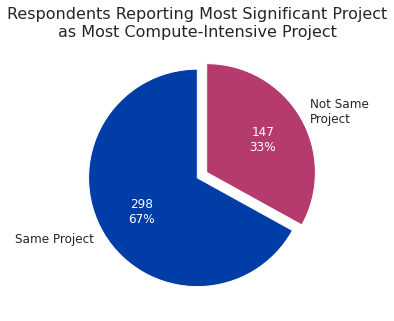

In [6]:
fig, ax = plt.subplots(figsize=(5, 5))

# Extract counts for people reporting that their most significant project was also their most compute-intensive project
counts = df.SameProject.value_counts().tolist()
labels = ['Same Project', 'Not Same\nProject']

# Create a pie chart, explode the smaller wedege, and return the wedge and text objects
wedges, text, autotexts = ax.pie(counts, autopct='', startangle = 90,
        explode = [0, 0.1], textprops = {'fontname': 'DejaVu Sans', 'fontsize': 12},
        labels = labels, colors=colors[:2])

# Adjust the labelling so that a percentage is displayed in white for each slice below a raw count
for a, c in zip(autotexts, counts):
    a.set_text(f'{c}\n{c * 100 / sum(counts):.0f}%')
    a.set_color('white')
    
# Add a title and save the figure
ax.set_title('Respondents Reporting Most Significant Project\nas Most Compute-Intensive Project', 
             fontsize=16, fontname='DejaVu Sans')
plt.savefig('../figures/paper/Fig3.jpg', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

# Figure 4: Budget Priorities

            Proportion        CI
Talent        0.518201  0.045319
Data          0.214133  0.037206
Compute       0.201285  0.036366
Evaluation    0.066381  0.022579


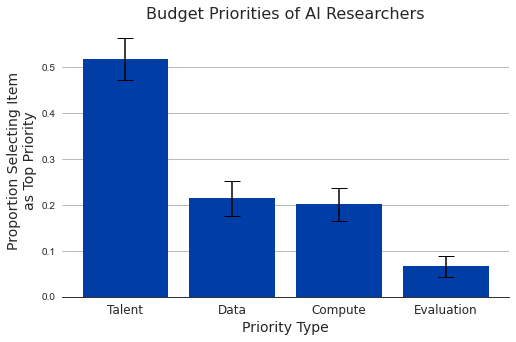

In [7]:
fig, ax = plt.subplots(figsize = (8,5))

# Extract the proportion of respondents selecting each of the four binned options and calculate the confidence intervals for each
props = np.array(df.PrioritySimplified.value_counts(normalize=True))
# NOTE TO CODE REVIEWER: I am using the equation 1.96 * sqrt( p * (1-p) / n ) to calculate the margins of error, as described by https://www.qualtrics.com/experience-management/research/margin-of-error/
# However, I am unsure if this is the appropriate equation to use and am open to correction!
cis = 1.96 * np.sqrt(props * (1 - props) / df.PrioritySimplified.value_counts().sum())

# Print the final data being plotted
data_df = pd.DataFrame({'Proportion': props, 'CI': cis}, index = df.PrioritySimplified.value_counts().index)
print(data_df)

# Plot the results on a bar chart and add error bars corresponding to the margins of error
ax.bar(np.arange(4), props, width=0.8, color=colors[0], edgecolor='none')
ax.errorbar(np.arange(4), props, yerr=cis, color='black', fmt='none')

# Adjsut the aesthetics of the plot and save it
ax.set_xticks(np.arange(4))
ax.set_xticklabels(df.PrioritySimplified.value_counts().index, fontsize=12, fontname='DejaVu Sans')
ax.set_title('Budget Priorities of AI Researchers', fontsize=16, fontname='DejaVu Sans')
ax.set_xlabel('Priority Type', fontsize=14, fontname='DejaVu Sans')
ax.set_ylabel('Proportion Selecting Item\nas Top Priority', fontsize=14, fontname='DejaVu Sans')
plt.savefig('../figures/paper/Fig4.jpg', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

# Figure 5: Research Plan Revisions

            Reject  Revise  Abandon
Compute      1.987   2.562    1.600
Data         2.512   2.852    2.027
Researcher   2.582   2.709    2.154


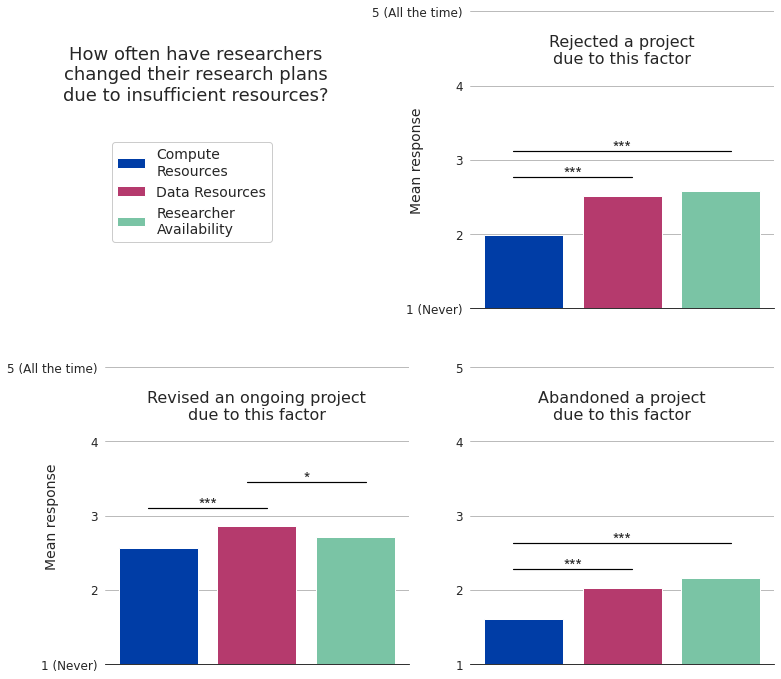

In [8]:
# Create a two-by-two grid of subplots (the top left grid will only contain a legend)
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(12,12))

# Create a dataframe to save mean values to as they are calculated
data_df = pd.DataFrame({'Reject': [0.] * 3, 'Revise': [0.] * 3, 'Abandon': [0.] * 3}, index = ['Compute', 'Data', 'Researcher'])

# Iterate over each of the three axes object, each of which refers to a different hypothetical situation
for i, (ax, situation) in enumerate(zip([axes[0][1], axes[1][0], axes[1][1]], ['Reject', 'Revise', 'Abandon'])):
    cols = [f'Compute{situation}', f'Data{situation}', f'Researcher{situation}']
    labs = ['Compute\nResources', 'Data Resources', 'Researcher\nAvailability']
    
    # For each factor, plot a single bar on the relevant axis showing the mean values (plus 1, since our data is stored in the range [0,4] but we want to plot in the range [1,5])
    for j, (col, lab) in enumerate(zip(cols, labs)):
        ax.bar(j, df[col].mean() + 1., color=colors[j], label=lab)
        
        # Also update the dataframe of final results
        data_df.loc[lab.split()[0], situation] = round(df[col].mean() + 1., 3)
    
    # Set the appropriate y-scale and remove xticks
    ax.set_ylim([1.,5.])
    ax.set_yticks(np.arange(1,6))
    ax.set_yticklabels([str(n) for n in np.arange(1, 6)], fontsize=12, fontname='DejaVu Sans')
    ax.set_xticks([])
    
    
    # Next, calculate each of the three two-way comparisons for this subplot to assess significant differences in arrays
    # Create an iterator variable that tracks how many horizontal bars have already been stacked on top of each other
    height = 0
    
    # Iterate over each relevant pair of columns 
    for (ind1, col1), (ind2, col2) in combinations(enumerate(cols), 2):
        
        # Calculate the p-value of a Mann-Whitney U test
        p = mannwhitneyu(df[col1].dropna(), df[col2].dropna())[1]
        
        # If the p-value is significant, and no horizontal bars have been plotted yet, then plot a horizontal bar just over the taller of the two columns in this comparison 
        if p < 0.05:
            if height == 0:
                height = max(df[col1].mean() + 1., df[col2].mean() + 1.) + 0.25
                
            # If a horizontal bar has already been plotted, then just plot the next one slightly above the last-plotted one
            else: height += 0.35
            ax.plot([ind1 - 0.1, ind2 + 0.1], [height] * 2, color='black', linewidth=1.2)
            
            # Choose the right annotation out of three options based on the p-value, and add an annotation to the plot, halfway along the horizontal bar
            annotation = '*' if p > 0.01 else '**'
            if p < 0.001: annotation = '***'
            ax.annotate(annotation, xy=[(ind1 + ind2) / 2, height + 0.05], ha='center', va='center', fontsize=16)
            
            
# For the top-right and bottom-left axes, adjust the labels of the y-ticks to show the range of responses
for ax in ([axes[0][1], axes[1][0]]):
    ax.set_yticklabels(['1 (Never)', '2', '3', '4', '5 (All the time)'], fontsize=12, fontname='DejaVu Sans')
    ax.set_ylabel('Mean response', fontsize=14, fontname='DejaVu Sans')
    ax.yaxis.set_label_coords(-.15, .5)

# Add annotations to each plot showing which hypothetical situation it represents
for ax, lab in zip([axes[0][1], axes[1][0], axes[1][1]], 
                   ['Rejected a project', 'Revised an ongoing project', 'Abandoned a project']):
    ax.annotate(f'{lab}\ndue to this factor', xy=(1., 4.3), ha='center', fontsize=16, fontname='DejaVu Sans')


# Adjust the top-left subplot so that it contains a legend and a question describing the results
handles, labels = axes[0][1].get_legend_handles_labels()
axes[0][0].legend(handles, labels, prop=basefont, loc=3, bbox_to_anchor=(0., 0.2))
axes[0][0].grid(False)
axes[0][0].axis(False)
axes[0][0].annotate('How often have researchers\nchanged their research plans\ndue to insufficient resources?',
                   xy=(0.3, 0.7), xycoords='axes fraction', ha='center', fontsize=18, fontname='DejaVu Sans')

# Print the full array of means
print(data_df)

# Save the final result
plt.savefig('../figures/paper/Fig5.jpg', dpi=300, bbox_inches='tight')

# NOTE TO CODE REVIEWER: for some reason I'm getting two extra significance results (ComputeRevise vs. ResearcherRevise at p = 0.03 and DataAbandon vs. ResearcherAbandon at p = 0.04)
# that I wasn't previously getting. I don't know if something in the data cleaning script I wrote somehow altered the results here? Or if I was previously calculating the p-values 
# incorrectly? Unsure if there's still an error present and would appreciate careful review here 

plt.show()
plt.close()

# Figure 6: Factor Importances and Predictions

Proportions:
            Decrease  Stay the same  Increase
Compute     0.340090       0.547297  0.112613
Algorithms  0.097065       0.534989  0.367946
——————————
Confidence Intervals:
            Decrease  Stay the same  Increase
Compute     0.044066       0.046300  0.029405
Algorithms  0.027569       0.046447  0.044908


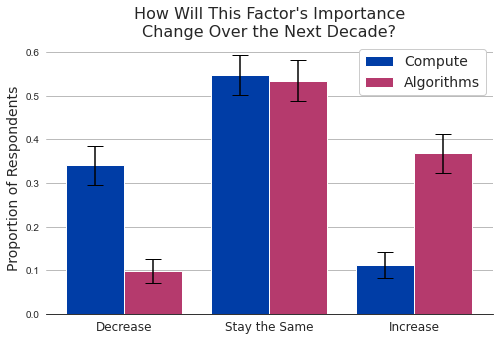

In [9]:
# Create an array to hold the values for the proportion of respondents saying that algorithms or compute will increase in importance, stay the same, or decrease
data = pd.DataFrame({'Decrease': [0,0,0], 'Stay the Same': [0,0,0], 'Increase': [0,0,0], 'Total': [0,0,0]}, 
                   index = ['Compute', 'Algorithms', 'Total'])

# Create a table based on how many respondents increased their assessment of a factor, decreased it, or did not change it
for lab in (['Compute', 'Algorithms']):
    data['Decrease'][lab] += len(df[df[f'Past{lab}'] > df[f'Future{lab}']])
    data['Stay the Same'][lab] += len(df[df[f'Past{lab}'] == df[f'Future{lab}']])
    data['Increase'][lab] += len(df[df[f'Past{lab}'] < df[f'Future{lab}']])
data['Total'] = np.sum(np.array(data)[:, :-1], axis=1)

# Calculate the proportion falling into each of the three categories for each factor, and then calculate the confidence intervals
props = np.array(data)[:-1, :-1] / np.expand_dims(np.array(data)[:-1, -1], axis=1)
# NOTE TO CODE REVIEWER: as before, I am using the equation 1.96 * sqrt( p * (1-p) / n ) to calculate the margins of error, as described by https://www.qualtrics.com/experience-management/research/margin-of-error/
# However, I am unsure if this is the appropriate equation to use and am open to correction!
cis = 1.96 * np.sqrt(props * (1 - props) / np.expand_dims(np.array(data)[:-1, -1], axis=1))

# Print the resulting proportions and confidence intervals being plotted
print('Proportions:')
print(pd.DataFrame({'Decrease': props[:, 0], 'Stay the same': props[:, 1], 'Increase': props[:, 2]}, index=['Compute', 'Algorithms']))
print('——————————\nConfidence Intervals:')
print(pd.DataFrame({'Decrease': cis[:, 0], 'Stay the same': cis[:, 1], 'Increase': cis[:, 2]}, index=['Compute', 'Algorithms']))

# Create the plot
fig, ax = plt.subplots(figsize=(8,5))

# Plot the bars for each proportion and add error bars
ax.bar(np.arange(3) - 0.2, props[0, :], width=0.4, color=colors[0], label='Compute')
ax.errorbar(np.arange(3) - 0.2, props[0, :], yerr=cis[0, :], color='black', fmt='none')
ax.bar(np.arange(3) + 0.2, props[1, :], width=0.4, color=colors[1], label='Algorithms')
ax.errorbar(np.arange(3) + 0.2, props[1, :], yerr=cis[1, :], color='black', fmt='none')

# Adjust aesthetics and add the legend, then save the resulting figure
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(data.columns[:-1], fontsize=12, fontname='DejaVu Sans')
ax.set_title('How Will This Factor\'s Importance\nChange Over the Next Decade?', fontsize=16, fontname='DejaVu Sans')
ax.set_ylabel('Proportion of Respondents', fontsize=14, fontname='DejaVu Sans')
ax.legend(prop=basefont)
plt.savefig('../figures/paper/Fig6.jpg', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

# Figure 7: Compute Usage in Industry and Academia

In [10]:
# First, do a simple significance test on both the CompGPUs and CompCost fields using a Mann-Whitney U test
print(mannwhitneyu(df[df.Sector == 'Academia'].CompCost.dropna(), df[df.Sector == 'Industry'].CompCost.dropna()))
print(mannwhitneyu(df[df.Sector == 'Academia'].CompGPUs.dropna(), df[df.Sector == 'Industry'].CompGPUs.dropna()))

MannwhitneyuResult(statistic=2603.5, pvalue=7.711725843479964e-08)
MannwhitneyuResult(statistic=8359.0, pvalue=0.12050595206341547)


Reported Cost Proportions
                    Academia  Industry
$0                  0.119617  0.000000
$1-1,000            0.133971  0.041667
$1,001-10,000       0.334928  0.208333
$10,001-100,000     0.311005  0.333333
$100,001-1,000,000  0.081340  0.312500
>$1,000,000         0.019139  0.104167
——————————
Reported GPU Hour Proportions
                Academia  Industry
None            0.095041  0.076923
<50             0.144628  0.089744
51-500          0.219008  0.269231
501-5,000       0.309917  0.230769
5,001-50,000    0.157025  0.166667
50,001-500,000  0.066116  0.115385
>500,000        0.008264  0.051282


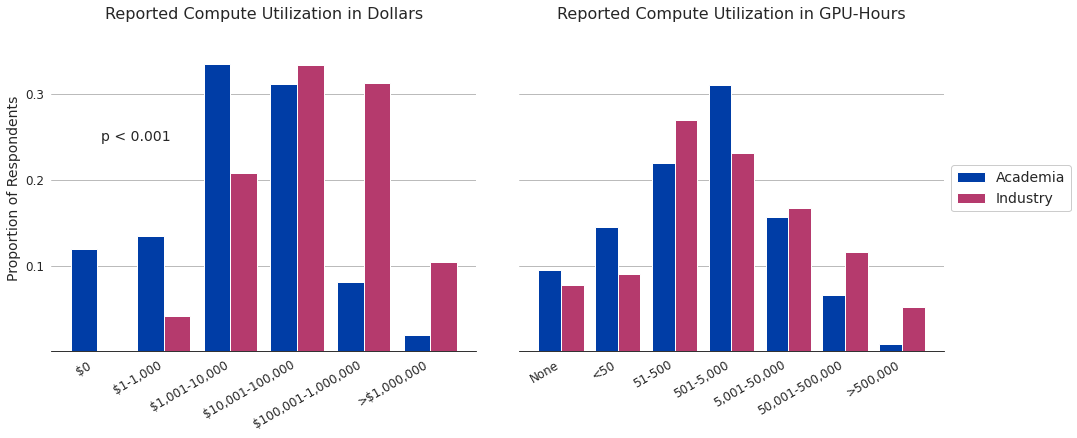

In [11]:
# Create a figure with two subplots, where the left hand side will show the differences in costs and the right hand side will show differences in GPU-hours used
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(16, 6))

# Read in the `answer_key` file, which holds the labels corresponding to different answers
answer_key = pd.read_csv('../data/answer_key.csv')
left_labs = answer_key[answer_key['comp_total_cost'].notna()].comp_total_cost.tolist()
right_labs = answer_key[answer_key['comp_training_cost'].notna()].comp_training_cost.tolist()

# Plot the data for reported cost for both academia and industry
ax0.bar(np.arange(len(left_labs)) - 0.2, df[df.Sector == 'Academia'].CompCost.value_counts(normalize=True).sort_index().tolist(), 
       width = 0.4, color=colors[0], label='Academia')
#NOTE: There are zero responses from industry for the lowest cost threshold 
ax0.bar(np.arange(len(left_labs)) + 0.2, [0] + df[df.Sector == 'Industry'].CompCost.value_counts(normalize=True).sort_index().tolist(), 
       width = 0.4, color=colors[1], label='Industry')

# Print out the results
print('Reported Cost Proportions')
print(pd.DataFrame({'Academia': df[df.Sector == 'Academia'].CompCost.value_counts(normalize=True).sort_index().tolist(),
             'Industry': [0] + df[df.Sector == 'Industry'].CompCost.value_counts(normalize=True).sort_index().tolist()}, index = left_labs))

# Adjust the aesthetics of the left-hand plot and add an annotation indicating the significance result
ax0.set_xticks(np.arange(len(left_labs)))
ax0.set_xticklabels(left_labs, rotation=30, ha='right', fontsize=12, fontname='DejaVu Sans')
ax0.set_ylim([0,0.38])
ax0.set_yticks([0.1,0.2,0.3])
ax0.set_yticklabels(['0.1', '0.2', '0.3'], fontsize=12, fontname='DejaVu Sans')
ax0.set_ylabel('Proportion of Respondents', fontsize=14, fontname='DejaVu Sans')
ax0.set_title('Reported Compute Utilization in Dollars', fontsize=16, fontname='DejaVu Sans')
ax0.annotate('p < 0.001', xy=(0.05, 0.25), va='center', fontsize=14, fontname='DejaVu Sans')


# Plot the data for reported GPU-hours for both academia and industry
ax1.bar(np.arange(len(right_labs)) - 0.2, df[df.Sector == 'Academia'].CompGPUs.value_counts(normalize=True).sort_index().tolist(), 
       width = 0.4, color=colors[0], label='Academia')
ax1.bar(np.arange(len(right_labs)) + 0.2, df[df.Sector == 'Industry'].CompGPUs.value_counts(normalize=True).sort_index().tolist(), 
       width = 0.4, color=colors[1], label='Industry')

# Print out the data 
print('——————————\nReported GPU Hour Proportions')
print(pd.DataFrame({'Academia': df[df.Sector == 'Academia'].CompGPUs.value_counts(normalize=True).sort_index().tolist(),
             'Industry': df[df.Sector == 'Industry'].CompGPUs.value_counts(normalize=True).sort_index().tolist()}, index = right_labs))

# Adjsut the aesthetics of the right-hand plot and add a legend to the right of the graph itself
ax1.set_xticks(np.arange(len(right_labs)))
ax1.set_xticklabels(right_labs, rotation=30, ha='right', fontsize=12, fontname='DejaVu Sans')
ax1.set_title('Reported Compute Utilization in GPU-Hours', fontsize=16, fontname='DejaVu Sans')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop=basefont)

# Adjust space between the two grids and save the figure
fig.subplots_adjust(wspace=0.1)
plt.savefig('../figures/paper/Fig7.jpg', dpi=300, bbox_inches='tight')

plt.show()

# Figure 8: Compute Needs and Access in Industry and Academia

In [12]:
# First, do a simple significance test on both the NeedChanges and AccessChanges fields using a Mann-Whitney U test
# Here we are comparing the distributions of reported changes in needs and access SEPARATELY for academia and industry, we are not comparing academia to industry
print(mannwhitneyu(df[df.Sector == 'Academia'].NeedChanges.dropna(), df[df.Sector == 'Academia'].AccessChanges.dropna()))
print(mannwhitneyu(df[df.Sector == 'Industry'].NeedChanges.dropna(), df[df.Sector == 'Industry'].AccessChanges.dropna()))

MannwhitneyuResult(statistic=60364.0, pvalue=3.954963341372279e-09)
MannwhitneyuResult(statistic=7549.5, pvalue=0.6531886501785902)


In [13]:
df[df.Sector == 'Academia'].NeedChanges.value_counts(normalize=True).sort_index().tolist()
np.arange(len(left_labs)) - 0.2

array([-0.2,  0.8,  1.8,  2.8,  3.8,  4.8])

Changes in Needs and Access Level for ACADEMIA
                   Needs    Access
Much less       0.003226  0.012903
Somewhat less   0.022581  0.032258
About the same  0.232258  0.393548
Somewhat more   0.429032  0.425806
Much more       0.312903  0.135484
——————————
Changes in Needs and Access Level for INDUSTRY
                   Needs    Access
Much less       0.008264  0.016529
Somewhat less   0.033058  0.008264
About the same  0.165289  0.206612
Somewhat more   0.421488  0.421488
Much more       0.371901  0.347107


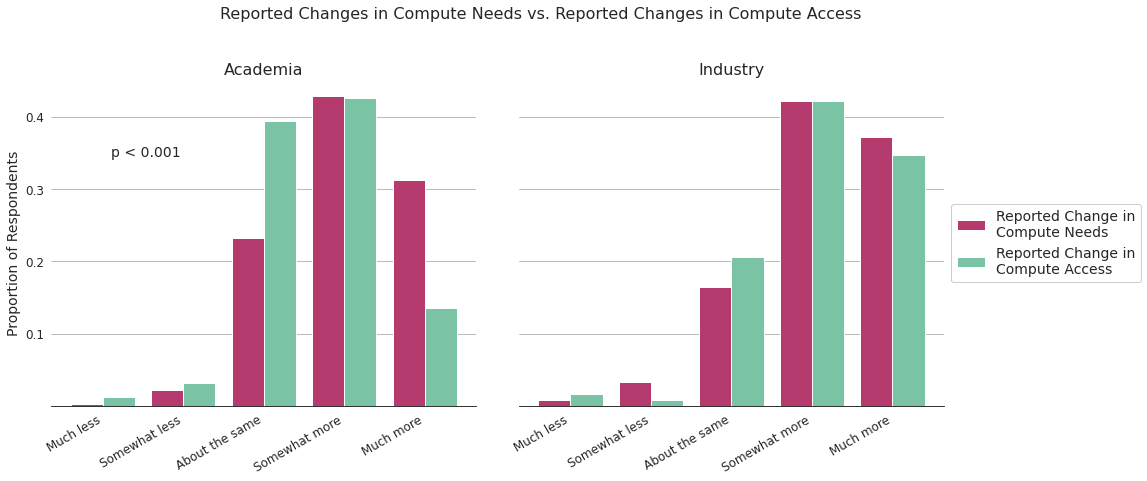

In [14]:
# Create the figure
fig, (ax0, ax1) = plt.subplots(ncols=2, sharey=True, figsize=(16, 6))

# Set the labels for different levels in the responses
labs = ['Much less', 'Somewhat less', 'About the same', 'Somewhat more', 'Much more']

# On the left-hand plot, plot the reported changes in compute NEEDS for academia in red and the reported changes in compute ACCESS in green
ax0.bar(np.arange(len(labs)) - 0.2, df[df.Sector == 'Academia'].NeedChanges.value_counts(normalize=True).sort_index().tolist(), 
       width = 0.4, color=colors[1], label='Reported Change in\nCompute Needs')
ax0.bar(np.arange(len(labs)) + 0.2, df[df.Sector == 'Academia'].AccessChanges.value_counts(normalize=True).sort_index().tolist(), 
       width = 0.4, color=colors[2], label='Reported Change in\nCompute Access')

# Print out the results
print('Changes in Needs and Access Level for ACADEMIA')
print(pd.DataFrame({'Needs': df[df.Sector == 'Academia'].NeedChanges.value_counts(normalize=True).sort_index().tolist(),
             'Access': df[df.Sector == 'Academia'].AccessChanges.value_counts(normalize=True).sort_index().tolist()}, index = labs))

# On the right-hand plot, plot the reported changes in compute NEEDS for industry in red and the reported changes in compute ACCESS in green
ax1.bar(np.arange(len(labs)) - 0.2, df[df.Sector == 'Industry'].NeedChanges.value_counts(normalize=True).sort_index().tolist(), 
       width = 0.4, color=colors[1], label='Reported Change in\nCompute Needs')
ax1.bar(np.arange(len(labs)) + 0.2, df[df.Sector == 'Industry'].AccessChanges.value_counts(normalize=True).sort_index().tolist(), 
       width = 0.4, color=colors[2], label='Reported Change in\nCompute Access')

# Print out the results
print('——————————\nChanges in Needs and Access Level for INDUSTRY')
print(pd.DataFrame({'Needs': df[df.Sector == 'Industry'].NeedChanges.value_counts(normalize=True).sort_index().tolist(),
             'Access': df[df.Sector == 'Industry'].AccessChanges.value_counts(normalize=True).sort_index().tolist()}, index = labs))

# Stylize the axes 
for ax in [ax0, ax1]:
    ax.set_xticks(np.arange(len(labs)))
    ax.set_xticklabels(labs, rotation=30, ha='right', fontsize=12, fontname='DejaVu Sans')
    ax.set_yticks([0.1,0.2,0.3,0.4])
    ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4'], fontsize=12, fontname='DejaVu Sans')
ax0.set_ylabel('Proportion of Respondents', fontsize=14, fontname='DejaVu Sans')

# Add titles to each subplot, a significance result to the left-hand plot, and a legend to the right of the right-hand plot, then adjust spacing and add a title
ax0.set_title('Academia', fontsize=16, fontname='DejaVu Sans')
ax0.annotate('p < 0.001', xy=(0.1, 0.35), va='center', fontsize=14, fontname='DejaVu Sans')
ax1.set_title('Industry', fontsize=16, fontname='DejaVu Sans')
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop=basefont)
fig.subplots_adjust(wspace=0.1)
fig.suptitle('Reported Changes in Compute Needs vs. Reported Changes in Compute Access', fontsize=16, fontname='DejaVu Sans', y=1.05, x=0.55)

plt.savefig('../figures/paper/Fig8.jpg', dpi=300, bbox_inches='tight')

plt.show()

# Figure 9: Academics' Reasons to Leave Academia

                     Proportions  Confidence Intervals
LeavingSalary           0.690722              0.065040
LeavingContribution     0.448454              0.069985
LeavingCompute          0.355670              0.067365
LeavingProjects         0.350515              0.067142
LeavingData             0.268041              0.062330


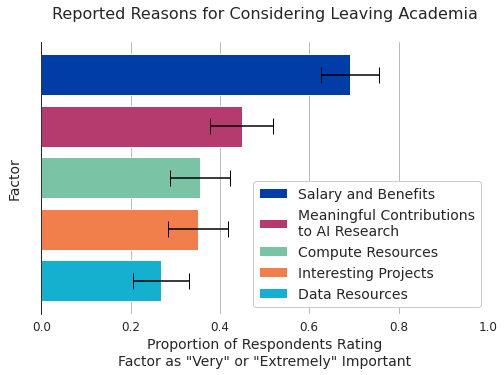

In [15]:
fig, ax = plt.subplots(figsize=(8,5))

# Create an array to hold the proportions of academics for each factor rating that factor as "very" or "extremely" important 
factors = ['LeavingSalary', 'LeavingData', 'LeavingCompute', 'LeavingProjects', 'LeavingContribution']
props = np.zeros(5,)
n = np.zeros(5,)
for i, lab in enumerate(factors):
    n[i] = len(df.dropna(subset = [lab]))
    props[i] = len(df[df[lab] >= 3.]) / n[i]
    
# Calculate confidence intervals using the same method as previously
cis = 1.96 * np.sqrt(props * (1-props) / n)

# Print out the data
print(pd.DataFrame({'Proportions': props[np.argsort(props)[::-1]], 
                   'Confidence Intervals': cis[np.argsort(props)[::-1]]}, 
                   index = np.array(factors)[np.argsort(props)[::-1]]))

# Plot the data for each factor in a different color and label it
labels = ['Salary and Benefits', 'Data Resources', 'Compute Resources', 'Interesting Projects', 'Meaningful Contributions\nto AI Research']
for i, (p, ci, lab) in enumerate(zip(props[np.argsort(props)[::-1]], cis[np.argsort(props)[::-1]], np.array(labels)[np.argsort(props)[::-1]])):
    ax.barh(5-i, p, color=colors[i], label=lab)
    ax.errorbar(p, 5-i, xerr=ci, color='black', fmt='none')

# Adjust aesthetics, add title and legend
ax.set_xlabel('Proportion of Respondents Rating\nFactor as \"Very\" or \"Extremely\" Important', fontsize=14, fontname='DejaVu Sans')
ax.set_xlim([0,1])
ax.set_xticks([0.,0.2,0.4,0.6,0.8,1.])
ax.set_xticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=12, fontname='DejaVu Sans')
ax.set_yticks([])
ax.set_ylabel('Factor\n', fontsize=14, fontname='DejaVu Sans')
ax.set_title('Reported Reasons for Considering Leaving Academia\n', fontsize=16, fontname='DejaVu Sans')
ax.grid(axis='x')
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(False)
ax.legend(prop=basefont, loc=4)

# Save the figure
fig.savefig('../figures/paper/Fig9.jpg', dpi=300, bbox_inches='tight')
    
plt.show()

# Figure 10: Concerns About Future Contributions in Industry and Academia

In [16]:
# First use a Mann-Whitney U test to evaluate whether the two distributions are statistically different
mannwhitneyu(df[df.Sector == 'Academia'].ContributionConcern.dropna(), df[df.Sector == 'Industry'].ContributionConcern.dropna())

MannwhitneyuResult(statistic=20223.5, pvalue=0.17754623450597506)

In [17]:
labs = answer_key[answer_key['contribution_concern'].notna()].contribution_concern.tolist()
labs

['Not at all concerned',
 'Slightly concerned',
 'Somewhat concerned',
 'Moderately concerned',
 'Extremely concerned']

                      Academia  Industry
Not at all concerned  0.200647  0.264463
Slightly concerned    0.190939  0.206612
Somewhat concerned    0.207120  0.165289
Moderately concerned  0.249191  0.231405
Extremely concerned   0.152104  0.132231


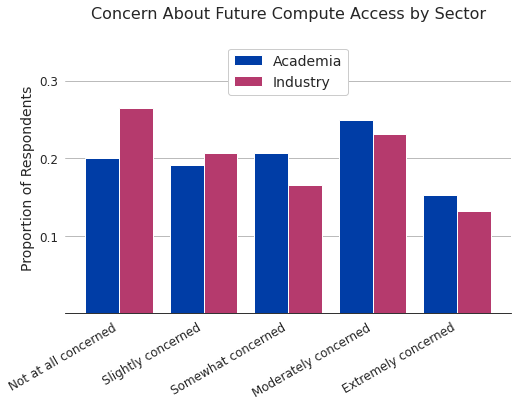

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))

# Assign labels for each response
labels = ['Not at all concerned', 'Slightly concerned', 'Somewhat concerned', 'Moderately concerned', 'Extremely concerned']

# Plot the data
ax.bar(np.arange(len(labels)) - 0.2, df[df.Sector == 'Academia'].ContributionConcern.value_counts(normalize=True).sort_index().tolist(), 
       width = 0.4, color=colors[0], label='Academia')
ax.bar(np.arange(len(labels)) + 0.2, df[df.Sector == 'Industry'].ContributionConcern.value_counts(normalize=True).sort_index().tolist(), 
       width = 0.4, color=colors[1], label='Industry')

# Print out the data
print(pd.DataFrame({'Academia': df[df.Sector == 'Academia'].ContributionConcern.value_counts(normalize=True).sort_index().tolist(),
                   'Industry': df[df.Sector == 'Industry'].ContributionConcern.value_counts(normalize=True).sort_index().tolist()},
                   index = labels))

# Adjust figure aesthetics, add title and axis labels, and add a legend
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=30, ha='right', fontsize=12, fontname='DejaVu Sans')
ax.set_ylim([0,0.35])
ax.set_yticks([0.1,0.2,0.3])
ax.set_yticklabels(['0.1', '0.2', '0.3'], fontsize=12, fontname='DejaVu Sans')
ax.set_ylabel('Proportion of Respondents', fontsize=14, fontname='DejaVu Sans')
ax.set_title('Concern About Future Compute Access by Sector\n', fontsize=16, fontname='DejaVu Sans')
ax.legend(prop=basefont, loc=9)

# Save the figure
plt.savefig('../figures/paper/Fig10.jpg', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

# Figure 11: Budget Priorities and Current Usage

In [58]:
# First evaluate the Spearman's Rho for the likelihood of selecting compute as top priority vs. compute usage
# NOTE: this seems like something we might want to better handle with a multinomial probit model?
x = df[(~df.CompGPUs.isna()) & (~df.PrioritySimplified.isna())].CompGPUs
y = df[(~df.CompGPUs.isna()) & (~df.PrioritySimplified.isna())].PrioritySimplified.apply(lambda x: int(x == 'Compute'))

spearmanr(x, y)

SpearmanrResult(correlation=0.14976464811052936, pvalue=0.005380499201170764)

Proportions by GPU-Hours Used in Most Compute-Intensive Project
               Compute      Data    Talent
<50           0.106667  0.213333  0.573333
51–500        0.182927  0.304878  0.451220
501–5,000     0.292929  0.151515  0.474747
5,001–50,000  0.240741  0.148148  0.555556
>50,000       0.294118  0.205882  0.470588
——————————
Margins of Error by GPU-Hours Used in Most Compute-Intensive Project
               Compute      Data    Talent
<50           0.069863  0.092715  0.111937
51–500        0.083679  0.099642  0.107707
501–5,000     0.089650  0.070630  0.098368
5,001–50,000  0.114033  0.094752  0.132535
>50,000       0.153159  0.135915  0.167778


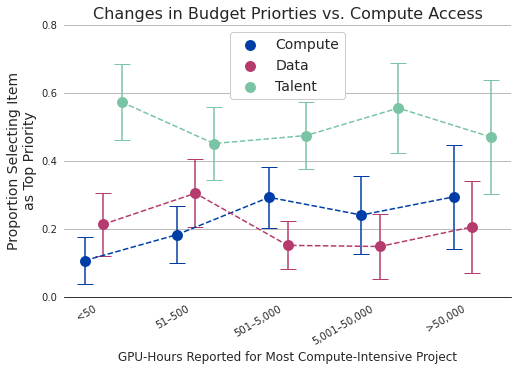

In [61]:
# Create arrays that will hold, for each level of compute usage, the number of respondents and the proportion selecting data/talent/compute as a top priority,
n = np.zeros((3,5))
counts = np.zeros((3,5))

# Fill in the arrays, while binning the bottom two and the top two GPU categories (due to low sample size)
buckets = [[0,1], [2], [3], [4], [5,6]]
n = np.array([len(df[(~df.PrioritySimplified.isna()) & (df.CompGPUs.isin(j))]) for j in buckets])
for i, priority in enumerate(['Compute', 'Data', 'Talent']):
    counts[i] = [len(df[(df.PrioritySimplified == priority) & (df.CompGPUs.isin(j))]) for j in buckets]
props = counts / n
    
# # NOTE TO CODE REVIEWER: I am using the equation 1.96 * sqrt( p * (1-p) / n ) to calculate the margins of error, as described by https://www.qualtrics.com/experience-management/research/margin-of-error/
# However, standard guidances says that for this to be valid, p * n and (1-p) * n should both be at above 10, and this isn't actually 
# true for some buckets (i.e. n for the lowest compute usage is 75 and the proporotion selecting compute is 10%)
moes = 1.96 * np.sqrt( props * (1-props) / n )

# Print out the calculated data
labels = ['<50', '51–500', '501–5,000', '5,001–50,000', '>50,000']
print('Proportions by GPU-Hours Used in Most Compute-Intensive Project')
print(pd.DataFrame({'Compute': props[0], 'Data': props[1], 'Talent': props[2]}, index=labels))
print('——————————\nMargins of Error by GPU-Hours Used in Most Compute-Intensive Project')
print(pd.DataFrame({'Compute': moes[0], 'Data': moes[1], 'Talent': moes[2]}, index=labels))

# Create the plot
fig, ax = plt.subplots(figsize=(8,5))

# Plot the results
for i, (p, moe, lab) in enumerate(zip(props, moes, ['Compute', 'Data', 'Talent'])):
    ax.errorbar(np.arange(len(labels)) - 0.15 + 0.2 * i, p, yerr=moe, ecolor=colors[i], fmt='--', color=colors[i])
    ax.scatter(np.arange(len(labels)) - 0.15 + 0.2 * i, p, s=80, facecolors=colors[i], edgecolors=colors[i], linewidths=2, label=lab)

# Adjust aesthetics, add title, add legend, and save figure 
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, fontsize=10, rotation=30, ha='right', fontname='DejaVu Sans')
ax.set_xlabel('GPU-Hours Reported for Most Compute-Intensive Project', fontsize=12, fontname='DejaVu Sans')
ax.set_yticks(np.arange(0.,1.,0.2))
ax.set_yticklabels([str(round(i, 1)) for i in np.arange(0.,1.,0.2)], fontsize=10, fontname='DejaVu Sans')
ax.set_ylabel('Proportion Selecting Item\nas Top Priority', fontsize=14, fontname='DejaVu Sans')
ax.set_title('Changes in Budget Priorties vs. Compute Access', fontsize=16, fontname='DejaVu Sans')
ax.legend(prop=basefont)
plt.savefig('../figures/paper/Fig11.jpg', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

# Figure 12: Contribution Concern and Current Usage

In [62]:
# Do the Spearman's Rho thing again, first for academia
# NOTE TO CODE REVIEWER: again, unsure about the use of this here
x = df[(~df.CompGPUs.isna()) & (~df.ContributionConcern.isna()) & (df.Sector == 'Academia')].CompGPUs
y = df[(~df.CompGPUs.isna()) & (~df.ContributionConcern.isna()) & (df.Sector == 'Academia')].ContributionConcern
print(spearmanr(x, y))

# And next for industry
x = df[(~df.CompGPUs.isna()) & (~df.ContributionConcern.isna()) & (df.Sector == 'Industry')].CompGPUs
y = df[(~df.CompGPUs.isna()) & (~df.ContributionConcern.isna()) & (df.Sector == 'Industry')].ContributionConcern
print(spearmanr(x, y))

SpearmanrResult(correlation=0.2825227928180886, pvalue=8.061836302192973e-06)
SpearmanrResult(correlation=0.16340849003460312, pvalue=0.15285689818691553)


Means by GPU-Hours Used in Most Compute-Intensive Project
              Academia  Industry
<50           1.413793  1.000000
51–500        1.981132  1.523810
501–5,000     2.026667  2.777778
5,001–50,000  2.342105  1.769231
>50,000       2.888889  1.538462
——————————
Confidence Intervals by GPU-Hours Used in Most Compute-Intensive Project
              Academia  Industry
<50           0.334115  0.665779
51–500        0.340100  0.614159
501–5,000     0.320009  0.463484
5,001–50,000  0.378931  0.891963
>50,000       0.522880  0.756355


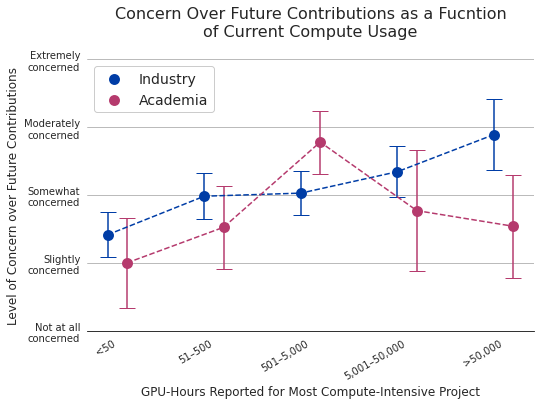

In [63]:
# Create arrays that will hold, for both academia and for industry, and for each level of compute usage, the number of respondents, the mean level of contribution concern,
# and the standard deviation in the reported levels of contribution concern
n = np.zeros((2,5))
means = np.zeros((2,5))
stds = np.zeros((2,5))

# Fill in the arrays, while binning the bottom two and the top two GPU categories (due to low sample size)
buckets = [[0,1], [2], [3], [4], [5,6]]
for i, sector in enumerate(['Academia', 'Industry']):
    n[i] = [len(df[(df.Sector == sector) & (df.CompGPUs.isin(j)) & (~df.ContributionConcern.isna())]) for j in buckets]
    means[i] = [df[(df.Sector == sector) & (df.CompGPUs.isin(j))].ContributionConcern.mean() for j in buckets]
    stds[i] = [df[(df.Sector == sector) & (df.CompGPUs.isin(j))].ContributionConcern.std() for j in buckets]
    
# Calculate margins of error using the equation 1.96 * std / sqrt(n)
# NOTE TO CODE REVIEWER: this is just the standard equation for a 95% confidence interval but if it isn't appropriate here please suggest alternatives
errors = 1.96 * stds / np.sqrt(n)

# Print out the calculated data
labels = ['<50', '51–500', '501–5,000', '5,001–50,000', '>50,000']
print('Means by GPU-Hours Used in Most Compute-Intensive Project')
print(pd.DataFrame({'Academia': means[0], 'Industry': means[1]}, index=labels))
print('——————————\nConfidence Intervals by GPU-Hours Used in Most Compute-Intensive Project')
print(pd.DataFrame({'Academia': errors[0], 'Industry': errors[1]}, index=labels))
    
# Create the plot
fig, ax = plt.subplots(figsize=(8,5))

# Plot the results
for i, (mean, err, lab) in enumerate(zip(means, errors, ['Industry', 'Academia'])):
    ax.errorbar(np.arange(len(labels)) - 0.1 + 0.2 * i, mean, yerr=err, ecolor=colors[i], fmt='--', color=colors[i])
    ax.scatter(np.arange(len(labels)) - 0.1 + 0.2 * i, mean, s=80, facecolors=colors[i], edgecolors=colors[i], linewidths=2, label=lab)

# Adjust figure aesthetics, add axis captions and title, add legend, and save the figure
y_labels = ['Not at all\nconcerned', 'Slightly\nconcerned', 'Somewhat\nconcerned', 'Moderately\nconcerned', 'Extremely\nconcerned']
ax.set_ylim([0.,4.])
ax.set_yticks(range(5))
ax.set_yticklabels(y_labels, fontsize=10, rotation=0, ha='right', fontname='DejaVu Sans')
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, fontsize=10, rotation=30, ha='right', fontname='DejaVu Sans')
ax.set_ylabel('Level of Concern over Future Contributions', fontsize=12, fontname='DejaVu Sans')
ax.set_xlabel('GPU-Hours Reported for Most Compute-Intensive Project', fontsize=12, fontname='DejaVu Sans')
ax.set_title('Concern Over Future Contributions as a Fucntion\nof Current Compute Usage\n', fontsize=16, fontname='DejaVu Sans')
ax.legend(prop=basefont)
plt.savefig('../figures/paper/Fig12.jpg', dpi=300, bbox_inches='tight')

plt.show()
plt.close()

# Figure 13: NAIRR Resources

            WantsData  WantsCompute  WantsStaff  WantsGrants  WantsStandards
Academia          171           205         125          280              79
Industry           80            79          32           70              44
Government         10             6           9            8               8


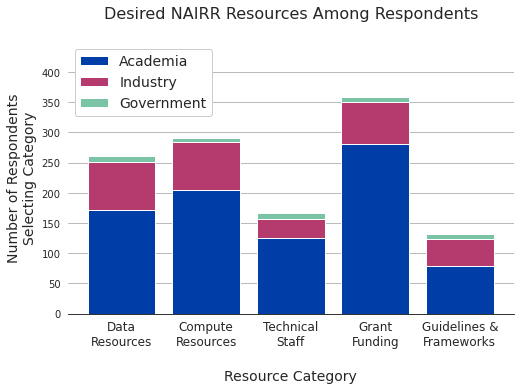

In [85]:
# Create an array to hold the data
data = pd.DataFrame({'WantsData': [0, 0, 0], 'WantsCompute': [0, 0, 0], 
                     'WantsStaff': [0, 0, 0], 'WantsGrants': [0, 0, 0], 
                     'WantsStandards': [0, 0, 0]}, 
                    index=['Academia', 'Industry', 'Government'])

# Fill in and print out the dataframe
for col in data.columns:
    for sector in data.index:
        data.loc[sector, col] = df[df.Sector == sector][col].sum()
print(data)

# Create the figure
fig, ax = plt.subplots(figsize=(8,5))

# Plot the data as a stacked bar plot
bottom = np.zeros(5,)
for i in range(3):
    ax.bar(np.arange(5), np.array(data.loc[data.index[i]]), bottom = bottom, 
           color=colors[i], label=data.index[i])
    bottom += np.array(data.loc[data.index[i]])
    
# Adjust the aesthetics, add a legend, and save the figure
labels = ['Data\nResources', 'Compute\nResources', 'Technical\nStaff', 'Grant\nFunding', 'Guidelines &\nFrameworks']
ax.set_xticks(np.arange(5))
ax.set_xticklabels(labels, fontsize=12, fontname='DejaVu Sans')
ax.set_xlabel('\nResource Category', fontsize=14, fontname='DejaVu Sans')
ax.set_yticks(np.arange(0, 450, 50))
ax.set_yticklabels([str(i) for i in np.arange(0, 450, 50)], fontsize=10, fontname='DejaVu Sans')
ax.set_ylabel('Number of Respondents\nSelecting Category', fontsize=14, fontname='DejaVu Sans')
ax.set_ylim([0,450])
ax.set_title('Desired NAIRR Resources Among Respondents\n', fontsize=16, fontname='DejaVu Sans')
ax.legend(prop=basefont, loc=0)
plt.savefig('../figures/paper/Fig13.jpg', dpi=300, bbox_inches='tight')

plt.show()
plt.close()